# Transfer Learning and Fine-Tuning

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

Steps of the Transfer Learning:

* Take layers from a previously trained model.
* Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
* Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
* Train the new layers on your dataset.

A last, optional step (second step), is **fine-tuning**, which consists of **unfreezing the entire model** you obtained above (or part of it), and re-training it on the new data with a **very low learning rate**. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

We'll demonstrate the typical workflow by taking a model pretrained on the ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification dataset.

**! Note**: The reason for using a very low learning rate at the second step of transfer learning is to allow the model to fine-tune its weights on the new task while preserving the knowledge it gained from the original task. In the second step, the model is fine-tuned on a smaller and more specific dataset related to the new task. The low learning rate during this step allows the model to make small adjustments to its weights without overfitting to the new data or forgetting the knowledge it gained in the first step.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Freezing layers: Understanding the trainable attribute

Layers & models have three weight attributes:

* **weights**: List of all weights variables of the layer
* **trainable_weights**: List of those that are meant to be updated (via gradient descent) to minimize the loss during training.
* **non_trainable_weights**: List of those that aren't meant to be trained. Typically they are updated by the model during the forward pass.

In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))   # Create the weigths

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In general, all weights are trainable weights. The only built-in layer that has **non-trainable weights** is the **BatchNormalization layer**. It uses non-trainable weights to keep track of the mean and variance of its inputs during training.

In [3]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weigths

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Setting trainable attribute to False

When a trainable weight becomes non-trainable, its value is no longer updated during training.



In [4]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


Make a model with 2 layers, freeze the first layer and Check the weights of layer1 have not changed during training

In [5]:
layer1 = keras.layers.Dense(3, activation='relu')
layer2 = keras.layers.Dense(3, activation='sigmoid')

model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep copy of a weights of layer1 for later reference
initial_layer1_weight_values = layer1.get_weights()

# Train the model
model.compile(optimizer='adam', loss='mse')
model.fit(np.random.random((2,3)), np.random.random((2,3)))

'''
Example output for np.random.random((2,3))

array([[0.44578764, 0.90248439, 0.63425646],
       [0.80618913, 0.34561086, 0.38662389]])
'''

# Check the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()

np.testing.assert_allclose(   # assert_allclose(): check that their shapes and all elements are equal 
    initial_layer1_weight_values[0], final_layer1_weights_values[0]
)   
np.testing.assert_allclose(
    initial_layer1_weight_values[1], final_layer1_weights_values[1]
)   

1/1 [==============================] - 7s 7s/step - loss: 0.1317


### Recursive Setting of the trainable attribute

If you set **trainable = False** on a model or on any layer that has sublayers, all children layers become non-trainable as well.

In [6]:
inner_model = keras.Sequential([
    keras.Input(shape=(3,)),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(3, activation='relu')
])

model = keras.Sequential([
    keras.Input(shape=(3,)),
    inner_model,
    keras.layers.Dense(3, activation='sigmoid')
])

model.trainable = False   # Freeze the outer model

assert inner_model.trainable == False   # All layers in inner_model are now frozen
assert inner_model.layers[0].trainable == False

### Transfer Learning Workflow

* Instantiate a base model and load pre-trained weights into it.
* Freeze all layers in the base model by setting trainable = False.
* Create a new model on top of the output of one (or several) layers from the base model.
* Train your new model on your new dataset.

More lightweight workflow could also be:

* Instantiate a base model and load pre-trained weights into it.
* Run your new dataset through it and record the output of one (or several) layers from the base model. This is called **feature extraction**.
* Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on your data, rather than once per epoch of training. So it's a lot faster & cheaper.

An issue with that second workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. 

Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',   # Load weights pre-trained on ImageNet
    input_shape=(150,150,3),
    include_top=False     # Do not include the ImageNet classifier at the top (Last layer)  
)

83683744/83683744 [==============================] - 8s 0us/step


In [8]:
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(150,150,3))

# Passing 'training=False' is important for fine-tuning
x = base_model(inputs, training=False)

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Dense classifier with a single unit (Binary classification)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [9]:
# Train the model on new Data
model_optimizer = keras.optimizers.Adam()
model_loss = keras.losses.BinaryCrossentropy(from_logits=True)
model_metrics = keras.metrics.BinaryAccuracy()

model.compile(optimizer=model_optimizer, loss=model_loss, metrics=[model_metrics])
# model.fit(new_dataset, epochs=USER_CODE, callbacks=USER_CODE, validation_data=USER_CODE)

'''
If from_logits is set to False, the input to the BinaryCrossentropy function is 
assumed to be a probability distribution. This means that the inputs should be in 
the range [0,1] and represent the predicted probabilities of the positive class. 
In this case, the function applies a sigmoid activation function to the inputs before 
computing the loss.

If from_logits is set to True, the input to the BinaryCrossentropy function is 
assumed to be logits. This means that the inputs can take any real value and do 
not need to be in the range [0,1]. In this case, the function applies a sigmoid 
activation function to the logits before computing the loss.

Setting from_logits to True can be useful in cases where the final layer of the 
neural network does not include an activation function, or when using a custom 
activation function that is not the sigmoid function. In general, it is recommended 
to set from_logits to True when working with binary classification problems, as 
this can improve numerical stability and performance.
'''

'\nIf from_logits is set to False, the input to the BinaryCrossentropy function is \nassumed to be a probability distribution. This means that the inputs should be in \nthe range [0,1] and represent the predicted probabilities of the positive class. \nIn this case, the function applies a sigmoid activation function to the inputs before \ncomputing the loss.\n\nIf from_logits is set to True, the input to the BinaryCrossentropy function is \nassumed to be logits. This means that the inputs can take any real value and do \nnot need to be in the range [0,1]. In this case, the function applies a sigmoid \nactivation function to the logits before computing the loss.\n\nSetting from_logits to True can be useful in cases where the final layer of the \nneural network does not include an activation function, or when using a custom \nactivation function that is not the sigmoid function. In general, it is recommended \nto set from_logits to True when working with binary classification problems, as

### Fine-tuning

Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting!

It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

It's also critical to use a **very low learning rate** at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at **risk of overfitting very quickly if you apply large weight updates**.

In [10]:
# Unfreeeze the base model
base_model.trainable = True

# Re-compile your model after any changes
model_optimizer = keras.optimizers.Adam(1e-5)
model.compile(optimizer=model_optimizer, loss=model_loss, metrics=[model_metrics])

# Train end-to-end. Stop before you overfit, tip: you could use tf.keras.callbacks.EarlyStopping
# model.fit(new_dataset, epochs=USER_CODE, callbacks=USER_CODE, validation_data=USER_CODE)

Calling compile() on a model is meant to "freeze" the behavior of that model. This implies that the trainable attribute values at the time the model is compiled should be preserved throughout the lifetime of that model, until compile is called again. Hence, if you change any trainable value, make sure to call compile() again on your model for your changes to be taken into account.

### BatchNormalization

* BatchNormalization contains **2 non-trainable weights** that get updated during training. (These variables tracks the **mean** and **variance** of the inputs)
* When you set a layer **trainable** parameter as **False**, the BatchNormalization layer will run inference mode (will not update its mean and variance statistics)
* When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training=False when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

### Transfer learning & fine-tuning with a custom training loop

In [11]:
# Create a base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# Freeze base model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150,150,3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model_optimizer = keras.optimizers.Adam()
model_loss = keras.losses.BinaryCrossentropy(from_logits=True)

''' Uncomment here after loading a dataset to new_dataset variable
# Iterate over the batches of a dataset
for inputs, targets in new_dataset:
  # Open a GradientTape
  with tf.GradientTape() as tape:
    # Forward pass
    predictions = model(inputs)
    # Compute the loss value for this batch
    loss_value = model_loss(targets, predictions)

  # Get gradient of loss wrt the trainable weights
  gradients = tape.gradient(loss_value, model.trainable_weights)
  # Update the weights of the model
  model_optimizer.apply_gradients(zip(gradients, model.trainable_weights))
'''

' Uncomment here after loading a dataset to new_dataset variable\n# Iterate over the batches of a dataset\nfor inputs, targets in new_dataset:\n  # Open a GradientTape\n  with tf.GradientTape() as tape:\n    # Forward pass\n    predictions = model(inputs)\n    # Compute the loss value for this batch\n    loss_value = model_loss(targets, predictions)\n\n  # Get gradient of loss wrt the trainable weights\n  gradients = tape.gradient(loss_value, model.trainable_weights)\n  # Update the weights of the model\n  model_optimizer.apply_gradients(zip(gradients, model.trainable_weights))\n'

### An end-to-end example

Dataset: Cats and Dogs
Base model = Xception

In [12]:
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    'cats_vs_dogs',
    # Reserve 10% for validation and 10% for test
    split=['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'],
    as_supervised=True   # include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5MIT43/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Visualizing sample images

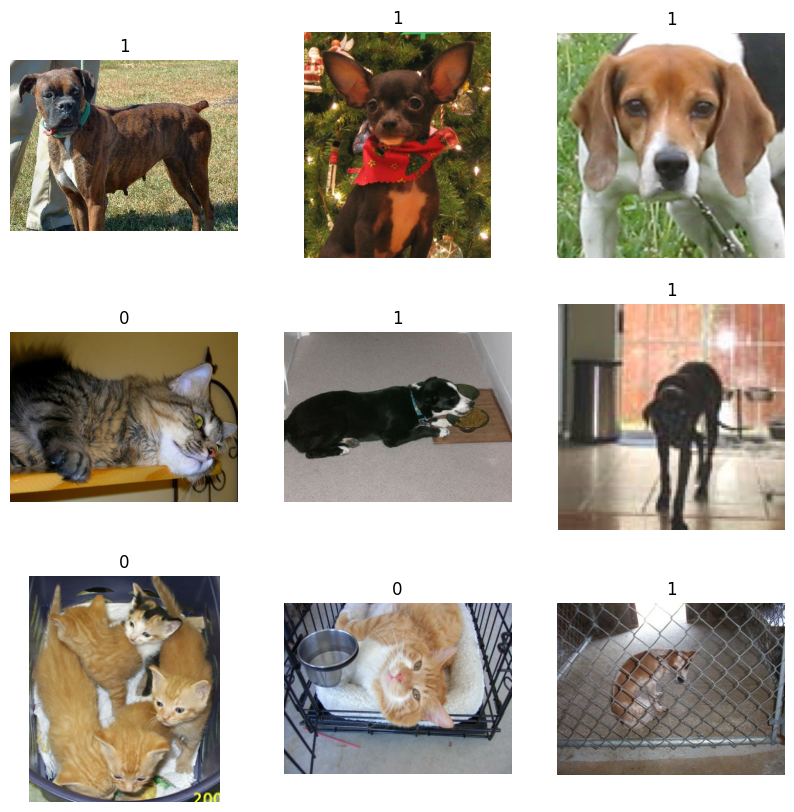

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. 

* Standardize to a fixed image size. We pick 150x150.
* Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.

In [14]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

Setting the **buffer_size** too **high** can lead to **memory overflow** and cause performance issues. **Smaller** buffer_size can result in more frequent data fetching, which may **slow down** the **training** process.

A common practice is to set the buffer_size to a multiple of the batch size, where the batch size is the number of data samples that are processed in each iteration of the training process. For example, if the batch size is 32, a buffer_size of 128 or 256 can be a good starting point.

In [15]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Data Augmentation

In [16]:
data_augmentation_layer = keras.Sequential([
    keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1)
])

'\ntf.expand_dims()\n\nIf you have a single image of shape [height, width, channels]\n>> image = tf.zeros([10,10,3])\nOutput: [10, 10, 3]\n\nYou can add an outer batch axis by passing axis=0:\nOutput: [1, 10, 10, 3]\n'

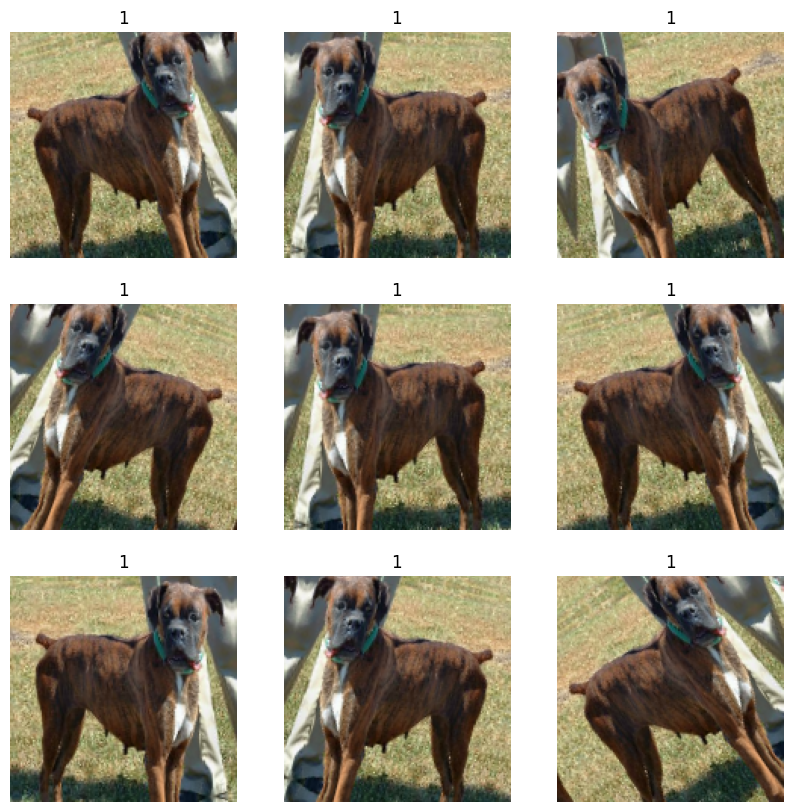

In [17]:
for images, labels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_img = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation_layer(
        tf.expand_dims(first_img, 0), 
        training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(int(labels[0]))
    plt.axis('off')

'''
tf.expand_dims()

If you have a single image of shape [height, width, channels]
>> image = tf.zeros([10,10,3])
Output: [10, 10, 3]

You can add an outer batch axis by passing axis=0:
Output: [1, 10, 10, 3]
'''

### Build the Model

* Add a Rescaling layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
* Add a **Dropout** layer before the classification layer, for regularization.
* Make sure to pass **training=False** when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when **training** is set to **True** such that **no values** are dropped during **inference**. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

(This is in contrast to setting trainable=False for a Dropout layer. trainable does not affect the layer's behavior, as Dropout does not have any variables/weights that can be frozen during training.)

In [18]:
# Create a base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False   # Do not include the ImageNet classifier at the top
)

# Freeze base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(150,150,3))
x = data_augmentation_layer(inputs)  # Random data augmentation

'''
Pre-trained Xception weights requires that input be scaled from (0,255) to a 
range of [-1, 1]

The rescaling layer outputs: (inputs * scale) + offset

To rescale an input in the [0, 255] range to be in the [0, 1] range, you would 
pass scale=1./255

To rescale an input in the [0, 255] range to be in the [-1, 1] range,you would 
pass scale=1./127.5, offset=-1.
'''
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                           

### Train the top layer

In [19]:
model.compile(optimizer=model_optimizer, loss=model_loss, metrics=[model_metrics])

epochs = 20

model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 50s 140ms/step - loss: 0.1736 - binary_accuracy: 0.9198 - val_loss: 0.0833 - val_binary_accuracy: 0.9660
Epoch 2/20
291/291 [==============================] - 34s 117ms/step - loss: 0.1179 - binary_accuracy: 0.9507 - val_loss: 0.0787 - val_binary_accuracy: 0.9695
Epoch 3/20
291/291 [==============================] - 33s 115ms/step - loss: 0.1117 - binary_accuracy: 0.9543 - val_loss: 0.0757 - val_binary_accuracy: 0.9695
Epoch 4/20
291/291 [==============================] - 39s 133ms/step - loss: 0.1029 - binary_accuracy: 0.9570 - val_loss: 0.0745 - val_binary_accuracy: 0.9716
Epoch 5/20
291/291 [==============================] - 36s 124ms/step - loss: 0.1076 - binary_accuracy: 0.9551 - val_loss: 0.0730 - val_binary_accuracy: 0.9721
Epoch 6/20
291/291 [==============================] - 32s 111ms/step - loss: 0.0978 - binary_accuracy: 0.9577 - val_loss: 0.0698 - val_binary_accuracy: 0.9729
Epoch 7/20
291/291 [==========================

### Fine-tuning of the entire model

Unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would damage the representations learned so far by the model.

In [20]:
# Unfreeze the base model. It is still in inference mode since we passed 
# training=False when calling it. 

base_model.trainable = True
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                           

In [25]:
model_optimizer = keras.optimizers.Adam(1e-5)   # For low learning rate

model.compile(optimizer=model_optimizer, loss=model_loss, metrics=[model_metrics])

epochs = 10

history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 179s 346ms/step - loss: 0.0104 - binary_accuracy: 0.9945 - val_loss: 0.0601 - val_binary_accuracy: 0.9819
Epoch 2/10
291/291 [==============================] - 108s 373ms/step - loss: 0.0140 - binary_accuracy: 0.9948 - val_loss: 0.0559 - val_binary_accuracy: 0.9828
Epoch 3/10
291/291 [==============================] - 105s 360ms/step - loss: 0.0131 - binary_accuracy: 0.9949 - val_loss: 0.0542 - val_binary_accuracy: 0.9824
Epoch 4/10
291/291 [==============================] - 100s 345ms/step - loss: 0.0102 - binary_accuracy: 0.9970 - val_loss: 0.0543 - val_binary_accuracy: 0.9819
Epoch 5/10
291/291 [==============================] - 104s 359ms/step - loss: 0.0059 - binary_accuracy: 0.9980 - val_loss: 0.0617 - val_binary_accuracy: 0.9807
Epoch 6/10
291/291 [==============================] - 102s 349ms/step - loss: 0.0050 - binary_accuracy: 0.9980 - val_loss: 0.0588 - val_binary_accuracy: 0.9824
Epoch 7/10
291/291 [====================

<Axes: >

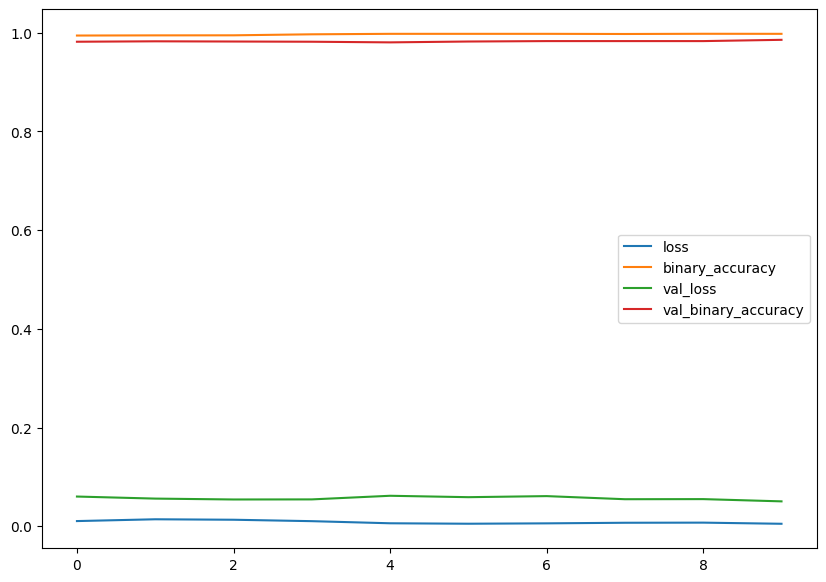

In [26]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 7))

In [24]:
model.predict(test_ds)

73/73 [==============================] - 9s 99ms/step


array([[-10.839156 ],
       [ 13.920051 ],
       [ 12.734295 ],
       ...,
       [ -5.4348025],
       [ 11.729798 ],
       [ 14.531653 ]], dtype=float32)

In [29]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

73/73 - 4s - loss: 0.1016 - binary_accuracy: 0.9798 - 4s/epoch - 60ms/step
Test Loss:  0.10161441564559937
Test Accuracy:  0.9797936081886292


### Reference

https://www.tensorflow.org/guide/keras/transfer_learning?hl=en